# Predicting house sale prices

## Introduction

In this project I am going to build a Linear regression model and tune its parameters. I will do some feature engineering to select the best features to train our model on. I will be working on a dataset containing housing parameters for the city of Ames, Iowa in the US from 2006 to 2010. The dataset can be found [here](http://jse.amstat.org/v19n3/decock/AmesHousing.txt)

### Summary of results

Validating our Lineat regression model with different number of features we got the best result using 4 features *Overall Qual, Neighborhood, Gr Liv Area and Exter Qual* and RMSE = 0.0642 on test data.

## Data exploration

In [25]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
%matplotlib inline

In [26]:
houses = pd.read_csv('data//AmesHousing.tsv',sep='\t')

Lets see what is the sape of data, how records look like and how many null values is there.

In [27]:
houses

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,2926,923275080,80,RL,37.0,7937,Pave,NaN,IR1,Lvl,...,0,NaN,GdPrv,NaN,0,3,2006,WD,Normal,142500
2926,2927,923276100,20,RL,NaN,8885,Pave,NaN,IR1,Low,...,0,NaN,MnPrv,NaN,0,6,2006,WD,Normal,131000
2927,2928,923400125,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal,132000
2928,2929,924100070,20,RL,77.0,10010,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2006,WD,Normal,170000


In [28]:
houses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
Order              2930 non-null int64
PID                2930 non-null int64
MS SubClass        2930 non-null int64
MS Zoning          2930 non-null object
Lot Frontage       2440 non-null float64
Lot Area           2930 non-null int64
Street             2930 non-null object
Alley              198 non-null object
Lot Shape          2930 non-null object
Land Contour       2930 non-null object
Utilities          2930 non-null object
Lot Config         2930 non-null object
Land Slope         2930 non-null object
Neighborhood       2930 non-null object
Condition 1        2930 non-null object
Condition 2        2930 non-null object
Bldg Type          2930 non-null object
House Style        2930 non-null object
Overall Qual       2930 non-null int64
Overall Cond       2930 non-null int64
Year Built         2930 non-null int64
Year Remod/Add     2930 non-null int64
Roof Style         29

## Feature engineering

Functions to transform columns data

In [29]:
to_drop = ['MS SubClass', 'MS Zoning','Year Built','Electrical', 'Functional','Garage Yr Blt',
          'Garage Cars','Garage Finish','PID','Street','Order','Mo Sold','Yr Sold','Sale Type',
           'Sale Condition','MS SubClass','MS Zoning','Bsmt Exposure','BsmtFin Type 1','BsmtFin Type 2']

categorical = ['Lot Area', 'Lot Shape','Land Contour', 'Utilities', 'Lot Config', 
               'Land Slope', 'Neighborhood', 'Bldg Type', 'House Style','Roof Style',
               'Roof Matl','Mas Vnr Type','Foundation','Heating','Garage Type','Paved Drive']

ordinal = ['Exter Qual', 'Exter Cond', 'Bsmt Qual', 'Bsmt Cond',
            'Heating QC','Kitchen Qual','Garage Qual', 'Garage Cond']

combine = ['Condition 1', 'Condition 2', 'Exterior 1st','Exterior 2nd']

def category_combine(df,col1,col2):
    b = pd.get_dummies(df[col1].astype('category'))
    b_col = pd.get_dummies(df[col2].astype('category')).columns
    a = pd.get_dummies(df[col1].astype('category'))
    if a.shape[1] > b.shape[1]:
        a = pd.get_dummies(df[col1].astype('category'))[b_col]
    for ind, row in a.iterrows():
        for pos, elem in enumerate(row):
            if elem == 0:
                a.iloc[ind,pos] = b.iloc[ind,pos]
    return a

def transform_features(train_df):
    # drop useless columns
    train_clean = train_df.drop(to_drop,axis=1).copy()
    
    # drop rows with more then 10% null values
    train_clean = train_clean.dropna(thresh=train_df.shape[0]*0.90 ,axis=1)
    
    # fill NaN mode value if less then 0.02 null values in column
    numerical = train_clean.select_dtypes(include=['float','int64'])
    numerical_null = numerical.isnull().sum()
    columns_fill = numerical_null[numerical_null<train_df.shape[0]*0.02].index
    train_clean[columns_fill] = train_clean[columns_fill].fillna(train_clean[columns_fill].mode())
    
    # modify boolean columns
    train_clean['Central Air'] = train_clean['Central Air'].apply(lambda col: 1 if col == 'Y' else 0)
    
    # transform Year 'Remod/Add' to present time since remod
    train_clean['years_since_remod'] = train_clean['Year Remod/Add'].apply(lambda col: 2010-int(col))
    train_clean.drop(['Year Remod/Add'],axis=1,inplace=True)
    
    # combining basement area
    train_clean['BsmtFin SF_total'] = train_clean['BsmtFin SF 1'] + train_clean['BsmtFin SF 2']
    train_clean.drop(['BsmtFin SF 1','BsmtFin SF 2'],axis=1,inplace=True)
    
    # transforming ordinal columns to numeric value
    train_clean[ordinal] = train_clean[ordinal].applymap(lambda x: 0 if x=='NA' else (1 if x == 'Po' else (2 if x == 'Fa' else (3 if x == 'TA' else (4 if x == 'Gd' else (5 if x == 'Ex' else 0))))))
    
    # combine extended categorical columns
    train_clean = pd.concat([train_clean,category_combine(train_clean,combine[0],combine[1])],axis=1)
    train_clean = pd.concat([train_clean,category_combine(train_clean,combine[2],combine[3])],axis=1)
    train_clean.drop(combine,axis=1,inplace=True)
    
    # Change nominal scale columns to category type
    train_clean[categorical] = train_clean[categorical].apply(lambda col: col.astype('category'))
    categorical_bool = pd.get_dummies(train_clean[categorical])
    train_clean = pd.concat([train_clean,categorical_bool],axis=1)
    train_clean.drop(categorical,axis=1,inplace=True)
    
    
    return train_clean

## Training / testing data

Spliting data randomly into two equal halfs

In [30]:
# split data into train and test sets
np.random.seed(1)
df = houses.loc[np.random.permutation(houses.index.values)]
train = df[:round(df.shape[0]/2)].reset_index(drop=True).copy()
test = df[round(df.shape[0]/2):].reset_index(drop=True).copy()

# clean data
train_transformed = transform_features(train).copy()

## Feature engineering cont.

In [31]:
# replacing null values
null_values = train_transformed.isnull().sum()
null_to_fill = null_values[null_values>0].index
train_transformed[null_to_fill] = train_transformed[null_to_fill].fillna(0)

### Correlation 

In [32]:
sorted_corrs = np.abs(train_transformed.corr()['SalePrice']).sort_values(ascending=False)
sorted_corrs

SalePrice         1.000000
Overall Qual      0.798576
Gr Liv Area       0.713549
Exter Qual        0.704637
Kitchen Qual      0.669620
                    ...   
Lot Area_5070     0.000075
Lot Area_8049     0.000075
Lot Area_9018     0.000072
Lot Area_11049    0.000043
Lot Area_10357    0.000043
Name: SalePrice, Length: 1265, dtype: float64

Lets select only strongly correlated columns and plot a heat map.

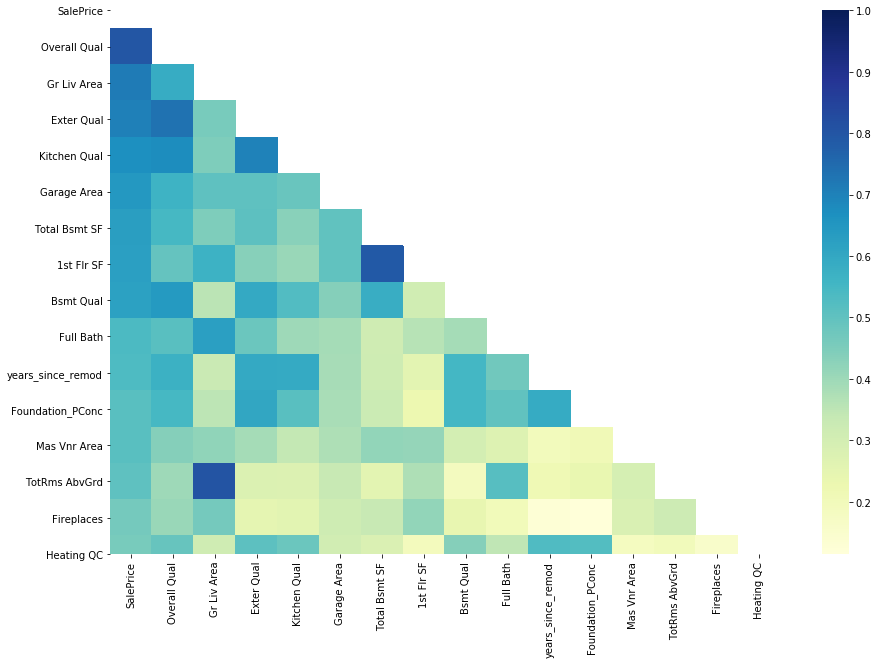

In [33]:
strong_corrs = sorted_corrs[sorted_corrs>0.45]
corrmat = train_transformed[strong_corrs.index]
feature_corr = abs(corrmat.corr())
mask = np.zeros_like(feature_corr)
mask[np.triu_indices_from(mask)] = True
ax = plt.figure(figsize=(15,10))
ax = sns.heatmap(feature_corr,cmap="YlGnBu",mask=mask)

Features *Gr Liv Area and TotRms AbvGr, 1st Flr SF and Total Bsmt SF* are strongly correlated.  Looking into documentation we can tell that each pair of columns reflects very similar information. To reduce information overload lets drop *TotRms AbvGrd and Total Bsmt SF*.

In [34]:
train_transformed = train_transformed[strong_corrs.index].drop(['TotRms AbvGrd','Total Bsmt SF'],axis=1)

### Searching hidden correlations
Thinking what else can impact the Sale Price and was not capture by the correlation matrix... lets try dig deeper into the original *Neighborhood* column and check whether is there any significant difference in price.

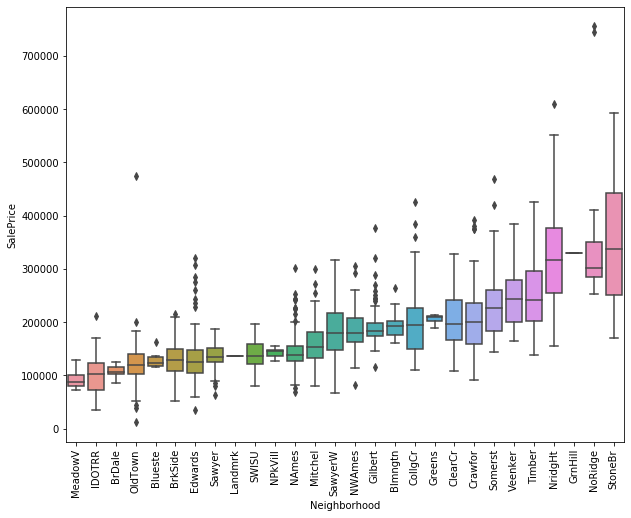

In [35]:
list_ordering = train[['Neighborhood','SalePrice']].groupby('Neighborhood').agg('mean').sort_values(by='SalePrice').index.values.tolist()
train['Neighborhood'] = pd.Categorical(train['Neighborhood'], categories=list_ordering) 
ax = plt.figure(figsize=(10,8))
ax = sns.boxplot(data=train, x='Neighborhood', y='SalePrice')
ax = plt.xticks(rotation=90)

It looks like there is some correlation between the neighborhood and the sale price. We can rank each location as holding different price range houses. The box plot is ordered by neighborhood mean in ascending order. We can rank each of the location in the following way:
- first 3 locations: 1
- from 4 to 12: 2
- location 13: 3
- from 14 to 21: 4
- from 22 to 24: 5
- last 3 locations: 6

Applying this numerical rank we can estimate how attractive each location is.

In [36]:
rank_neighborhood = {}
for n, area in enumerate(list_ordering):
    if n < 3:
        rank_neighborhood[area] = 1.
    elif n>=3 and n <12:
        rank_neighborhood[area] = 2.
    elif n==12:
        rank_neighborhood[area] = 3.
    elif n>12 and n <21:
        rank_neighborhood[area] = 4.
    elif n>=21 and n <24:
        rank_neighborhood[area] = 5.
    elif n>=24:
        rank_neighborhood[area] = 6.
        
neighborhood_clean = train['Neighborhood'].replace(rank_neighborhood)
train_transformed['neighborhood_clean'] = neighborhood_clean

### Feature normalization

In [37]:
def normalize_features(df):
    normalized = df.apply(lambda col: (col-col.min())/(col.max()-col.min()))
    return normalized

Once the data is normalized lets check columns variance. When the values in a feature column have low variance, they don't meaningfully contribute to the model's predictive capability.

In [38]:
train_normalized = normalize_features(train_transformed)
train_normalized.var()

SalePrice             0.012075
Overall Qual          0.031311
Gr Liv Area           0.009792
Exter Qual            0.035861
Kitchen Qual          0.027160
Garage Area           0.023382
1st Flr SF            0.008065
Bsmt Qual             0.031524
Full Bath             0.019056
years_since_remod     0.121457
Foundation_PConc      0.247149
Mas Vnr Area          0.018090
Fireplaces            0.047524
Heating QC            0.100888
neighborhood_clean    0.084472
dtype: float64

There are two outliers *1st Flr SF* with very low variance and *Foundation_PConc* with very high which comes from our dummies category transformation so it contains either 0 or 1. Lets drop both.

In [39]:
train_normalized = train_normalized.drop(['1st Flr SF','Foundation_PConc'],axis=1)

### Feature selection

In [40]:
best_features = abs(train_normalized.corr()['SalePrice']).sort_values(ascending=False)
feature_order = best_features.index

best_features[1:]

Overall Qual          0.798576
neighborhood_clean    0.725073
Gr Liv Area           0.713549
Exter Qual            0.704637
Kitchen Qual          0.669620
Garage Area           0.643913
Bsmt Qual             0.620130
Full Bath             0.539218
years_since_remod     0.533617
Mas Vnr Area          0.513425
Fireplaces            0.466369
Heating QC            0.458902
Name: SalePrice, dtype: float64

### Transforming test dataset

In [41]:
# adding new columns to match train data
test['years_since_remod'] = test['Year Remod/Add'].apply(lambda col: 2010-int(col))
test['neighborhood_clean'] = test['Neighborhood'].replace(rank_neighborhood)

# selecting the same columns as for train data
test_clean = test[feature_order].copy()

# cleaning text column
test_object = test_clean.select_dtypes(include=['object']).columns
test_clean[test_object] = test_clean[test_object].applymap(lambda x: 0 if x=='NA' else (1 if x == 'Po' else (2 if x == 'Fa' else (3 if x == 'TA' else (4 if x == 'Gd' else (5 if x == 'Ex' else 0))))))
test_normalized = normalize_features(test_clean)

# filling null values`
null_values = test_normalized.isnull().sum()
null_to_fill = null_values[null_values>0].index
test_normalized[null_to_fill] = test_normalized[null_to_fill].fillna(0)

### Model validation

In [42]:
# model validation
def cross_validation(train,test):
    model_rmse = {}
    for n_col in range(2,len(feature_order)+1):
        attributes_model = feature_order[:n_col]
        train_df = train[attributes_model]
        features = train_df.drop('SalePrice',axis=1)
        target = train['SalePrice']
        lr = LinearRegression()
        lr.fit(features,target)
        test_pred = lr.predict(test[features.columns])
        rmse = mean_squared_error(test['SalePrice'],test_pred,squared=False)
        model_rmse['{}-attributes'.format(n_col-1)] = rmse
    return model_rmse

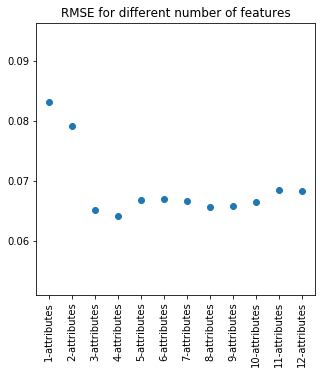

In [43]:
# validating model on different features
model_rmse = cross_validation(train_normalized,test_normalized) 

# ploting results
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1,1,1)
ax.scatter(model_rmse.keys() ,model_rmse.values())
ax = plt.xticks(rotation=90)
plt.title('RMSE for different number of features')
plt.show()

### Selecting the best model

In [44]:
model_rmse['4-attributes']

0.06419545109411466

## Conclusion

Using 4 features *Overall Qual, neighborhood_clean, Gr Liv Area, Exter Qual* we got RMSE = 0.0642 on test data.